In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import os
import seaborn as sn
import numpy as np
from multi_scale_unet import UNET
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as tvtransforms
import time
import torch
import segmentation_models_pytorch as smp
import metrics as smpmetrics
import albumentations as A
from tqdm import tqdm
from meter import AverageValueMeter
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import albumentations as A
from torch.utils.data import DataLoader

import torchmetrics
from torchmetrics import ConfusionMatrix
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from labelbox import Client, OntologyBuilder
from labelbox.data.annotation_types import Geometry
from PIL import Image
import numpy as np
import os
import config

In [2]:
MULTICLASS_MODE: str = "multiclass"
ENCODER = "resnet18"
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'ocean', 'wetsand', 'buildings', 'vegetation', 'drysand']
ACTIVATION = None
BATCH_SIZE = 1
MODEL_NAME = 'wavelet-unet'
MIN_HEIGHT = 256
MIN_WIDTH = 256
#MIN_HEIGHT = 2048
#MIN_WIDTH = 256
EPOCHS = 100
DEVICE = 'cuda'
TRAIN_IMG_DIR = "../../CoastSat/data/blackpool/images/train/"
TRAIN_MASK_DIR = "../../CoastSat/data/blackpool/images/trainannot/"
TEST_IMG_DIR = "../../CoastSat/data/blackpool/images/test/"
TEST_MASK_DIR = "../../CoastSat/data/blackpool/images/testannot/"
VAL_IMG_DIR = '../../CoastSat/data/blackpool/images/val/'
VAL_MASK_DIR = '../../CoastSat/data/blackpool/images/valannot/'

Validation image date: 2017-01-05-11-24-39
Training image date: 

In [3]:
avail = torch.cuda.is_available() # just checking which devices are available for training
devCnt = torch.cuda.device_count()
devName = torch.cuda.get_device_name(0)
print("Available: " + str(avail) + ", Count: " + str(devCnt) + ", Name: " + str(devName))

Available: True, Count: 1, Name: NVIDIA GeForce RTX 3070


In [4]:
class Dataset(Dataset):
    """This method creates the dataset from given directories"""
    def __init__(self, image_dir, mask_dir, transform=None):
        """initialize directories

        :image_dir: TODO
        :mask_dir: TODO
        :transform: TODO

        """
        self._image_dir = image_dir
        self._mask_dir = mask_dir
        self._transform = transform
        self.images = os.listdir(image_dir)

        self.mapping = {(0, 0, 0): 0, # background class (black)
                        (0, 0, 255): 1,  # 0 = class 1
                        (225, 0, 225): 2,  # 1 = class 2
                        (255, 0, 0): 3,  # 2 = class 3
                        (255, 225, 225): 4, # 3 = class 4
                        (255, 255, 0): 5}  # 4 = class 5

    def __len__(self):
        """returns length of images
        :returns: TODO

        """
        return len(self.images)
    
    def mask_to_class_rgb(self, mask):
        #print('----mask->rgb----')
        h=20
        w=722
        mask = torch.from_numpy(mask)
        mask = torch.squeeze(mask)  # remove 1

        # check the present values in the mask, 0 and 255 in my case
        #print('unique values rgb    ', torch.unique(mask)) 
        # -> unique values rgb     tensor([  0, 255], dtype=torch.uint8)

        class_mask = mask
        class_mask = class_mask.permute(2, 0, 1).contiguous()
        h, w = class_mask.shape[1], class_mask.shape[2]
        mask_out = torch.zeros(h, w, dtype=torch.long)

        for k in self.mapping:
            idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))         
            validx = (idx.sum(0) == 3)          
            mask_out[validx] = torch.tensor(self.mapping[k], dtype=torch.long)

        # check the present values after mapping, in my case 0, 1, 2, 3PSPNet
        #print('unique values mapped ', torch.unique(mask_out))
        # -> unique values mapped  tensor([0, 1, 2, 3])
       
        return mask_out

    def __getitem__(self, index):
        """TODO: Docstring for __getitem__.
        :returns: TODO

        """
        img_path = os.path.join(self._image_dir, self.images[index])
        mask_path = os.path.join(self._mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = self.mask_to_class_rgb(mask).cpu().detach().numpy()


        if self._transform is not None:
            augmentations = self._transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            

        return image, mask

In [5]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    """
    This method creates the dataloader objects for the training loops

    :train_dir: directory of training images
    :train_mask_dir: directory of training masks
    :val_dir: validation image directory

    :returns: training and validation dataloaders
recall
    """
    train_ds = Dataset(image_dir=train_dir,
                             mask_dir=train_mask_dir,
                             transform=train_transform)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = Dataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [6]:
    """
    Training and testing image transforms using albumentation libraries
    """
test_transform = A.Compose(
    [A.PadIfNeeded(min_height=MIN_HEIGHT, min_width=MIN_WIDTH, border_mode=4),A.Resize(MIN_HEIGHT, MIN_WIDTH),]
)

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=MIN_HEIGHT, min_width=MIN_WIDTH, border_mode=4),
        A.Resize(MIN_HEIGHT, MIN_WIDTH),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [7]:
# get the dataloaders
trainDL, testDL = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                           TEST_IMG_DIR, TEST_MASK_DIR,
                                           BATCH_SIZE, train_transform,
                                           test_transform)


In [8]:

def visualize(**images):
    """Method to generate visualization of the training images
    """
    n = len(images)
    plt.figure(figsize=(16,5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

torch.Size([32, 512])
torch.Size([3, 32, 512])
{1: 10531, 2: 642, 3: 2185, 4: 2263, 5: 763}
torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)


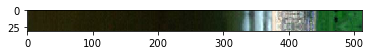

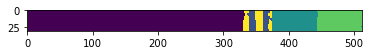

torch.Size([3, 32, 512]) torch.uint8 <class 'torch.Tensor'> torch.Size([32, 512]) torch.int32 <class 'torch.Tensor'> tensor(1, dtype=torch.int32) tensor(255, dtype=torch.uint8) tensor(1, dtype=torch.int32) tensor(5, dtype=torch.int32)
6


In [9]:
transforms_delete = A.Compose([
        A.PadIfNeeded(32,512),
        A.Resize(32, 512),
        ToTensorV2(),
    ], )
dataset = Dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=transforms_delete)

image, mask = dataset[10] # get some sample

#visualize(
#    image=image,
#    mask=mask.squeeze()
#)
#mask = mask.unsqueeze(0)

print(mask.shape)
print(image.shape)
unique, counts = np.unique(mask, return_counts=True)
print(dict(zip(unique, counts)))
print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

plt.imshow(image.permute(1,2,0))
plt.show()

plt.imshow(mask)
plt.show()

#mask = mask.unsqueeze(0)
#print(mask.shape)

print(image.shape, image.dtype, type(image), mask.shape, 
mask.dtype, type(mask), mask.min(), 
image.max(), mask.min(), mask.max())

print(len(CLASSES))


In [10]:
# initialize model
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

#wavelet_model = UNET(in_channels=3, out_channels=6).to(DEVICE)

In [11]:


loss = smp.losses.DiceLoss(mode="multiclass")
loss.__name__ = 'Dice_loss'

# metrics have been defined in the custom training loop as giving them in a list object did not work for me
metrics = [

]

# define optimizer and learning rate
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

In [12]:
def check_accuracy(metrics, loader, model, device='cpu'):
    """ Custom method to calculate accuracy of testing data
    :loader: dataloader objects
    :model: model to test
    :device: cpu or gpu
    """

    # define scores to track
    f1_score = 0
    precision_score = 0
    recall_score = 0
    iou_score = 0
    dataset_size = len(loader.dataset)  # number of images in the dataloader
    y_pred = []
    y_true = []

    model.eval() # set model for evaluation
    with torch.no_grad():  # do not calculate gradients
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            y = y.to(torch.int64)
            x = x.permute(0,1,2,3) # ===========================================================================
            #x = x.permute(0,2,3,1)
            preds = model(x.float().contiguous())  # get pixel predictions from image tensor
            preds = torch.argmax(preds, dim=1).unsqueeze(1).int()  # get maximum values of tensor along dimension 1


            #print(preds.shape, y.shape)
            tp, fp, fn, tn = smpmetrics.get_stats(preds, y, mode='multiclass', num_classes=6)  # get tp,fp,fn,tn from predictions

            # compute metric
            a = smpmetrics.iou_score(tp, fp, fn, tn, reduction="macro")
            b = smpmetrics.f1_score(tp,fp,fn,tn, reduction='macro')
            c = smpmetrics.precision(tp,fp,fn,tn, reduction='macro')
            d = smpmetrics.recall(tp,fp,fn,tn, reduction='macro')


            y_pred.extend(preds)
            y_true.extend(y)

            #confmat = ConfusionMatrix(num_classes=6)
            #print(preds.shape, y.shape)
            #print(confmat(preds.cpu(), y.cpu()))


            iou_score += a
            f1_score += b
            precision_score += c
            recall_score += d

    iou_score /= dataset_size  # averaged score across all images in directory
    f1_score /= dataset_size
    precision_score /= dataset_size
    recall_score /= dataset_size
    #print(type(y_pred[0]), y_pred[0].shape, y_true[0].shape, len(y_pred), len(y_true), )

    xut = y_pred[0]
    xutrue=y_true[0]

    confmat = ConfusionMatrix(num_classes=6, normalize='true')
    df_cm = confmat(xut.cpu(), xutrue.cpu())
    df_cm = pd.DataFrame(df_cm.numpy())

    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

    print(df_cm)
    print(xut.shape)

    
    print('IOU Score: {} | F1 Score: {} | Precision Score: {} | Recall Score: {}'.format(iou_score, f1_score, precision_score, recall_score))
    #model.train()


In [ ]:
scaler = torch.cuda.amp.GradScaler()

def train_wavelet(loader, model, optimizer, loss_fn, scaler):
    """TODO: Docstring for train_fn.

    :loader: TODO
    :model: TODO
    :optimizer: TODO
    :loss_fn: TODO
    :scaler: TODO
    :returns: TODO

    """
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE).float()
        targets = targets.to(device=DEVICE)
        targets = targets.long()
        data = data.permute(0,3,1,2)  # correct shape for image
        targets = targets.squeeze(1)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data.contiguous())
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update loop
        loop.set_postfix(loss=loss.item())
        del loss, predictions

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """ Custom training loop for models

    :loader: dataloader object
    :model: model to train
    :optimizer: training optimizer
    :loss_fn: loss function
    :scaler: scaler object
    :returns:

    """
    loop = tqdm(loader)  # just a nice library to keep track of loops
    model = model.to(DEVICE)# ===========================================================================
    for batch_idx, (data, targets) in enumerate(loop):  # iterate through dataset
        data = data.to(device=DEVICE).float()
        targets = targets.to(device=DEVICE).float()
        targets = targets.unsqueeze(1)
        data = data.permute(0,3,2,1)  # correct shape for image# ===========================================================================
        targets = targets.to(torch.int64)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss_values.append(loss.item())
        #run['training/batch/loss'].log(loss)

        #update loop
        loop.set_postfix(loss=loss.item())

for epoch in range(EPOCHS):  # run training and accuracy functions and save model
    train_fn(trainDL, model, optimizer, loss, scaler)
    #train_wavelet(trainDL, wavelet_model, optimizer, loss, scaler)
    check_accuracy(metrics, testDL, model, DEVICE)
    torch.save(model, './{}.pth'.format(MODEL_NAME))

In [ ]:
# Predict using saved model

val_transform = A.Compose(  # validation image transforms
    [A.Resize(MIN_HEIGHT, MIN_WIDTH),ToTensorV2()]
)


In [ ]:
model_eval = torch.load('./saved_models/{}/{}.pth'.format(MODEL_NAME,MODEL_NAME))  # load model
#model_eval = torch.load('./{}.pth'.format(MODEL_NAME))  # load model
print('{} loaded'.format(MODEL_NAME))

In [ ]:
# import required module
import os
# assign directory
#directory = '../../CoastSat/data/blackpool/images/val/'
directory = '../bp_validation_images/'

#colors = [(0, 0, 255/255), (225/255, 0, 225/255), (255/255, 0, 0), (255/255, 225/255, 225/255), (255/255, 255/255, 0)]
#value_names = ['ocean', 'wetsand', 'buildings', 'vegetation', 'drysand']

image_matrix5 = np.zeros(shape=(256,256))


# iterate over files in
# that directory
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        val_image = Image.open(f)
        transformed = val_transform(image=np.array(val_image))
        image_transformed = transformed['image']

        batch_tensor = torch.unsqueeze(image_transformed, 0)
        out = model_eval(batch_tensor.to(device=DEVICE).float())

        preds = torch.argmax(out, dim=1)
        preds = preds.cpu().detach().permute(1,2,0)

        preds = preds[:,:,0]

        preds_np = preds.numpy()

        image_matrix5 = np.vstack((image_matrix5, preds_np))

image_matrix5 = image_matrix5[256:,:]

plt.imshow(image_matrix5)
rescaled = (255.0 / image_matrix5.max() * (image_matrix5 - image_matrix5.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
im = im.resize((256,2048))
im.save('test_2.png')

plt.axis('off')
#plt.savefig('blackpool_preds_full_image_{}.png'.format(MODEL_NAME))
matplotlib.image.imsave('bp_full_2_{}.png'.format(MODEL_NAME), image_matrix5)
plt.show()




stack all tiled validation images together and save image as predictions

In [ ]:
# import required module
import os
# assign directory
directory = '../../CoastSat/data/blackpool/images/val/'
#directory = '../bp_validation_images/'
image_matrix = np.zeros(shape=(10,256))
f1_eval = 0
precision_eval = 0
recall_eval = 0
iou_eval = 0
colors = [(0, 0, 255/255), (225/255, 0, 225/255), (255/255, 0, 0), (255/255, 225/255, 225/255), (255/255, 255/255, 0)]
value_names = ['ocean', 'wetsand', 'buildings', 'vegetation', 'drysand']

# iterate over files in
# that directory
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        val_image = Image.open(f)
        transformed = val_transform(image=np.array(val_image))
        image_transformed = transformed['image']

        batch_tensor = torch.unsqueeze(image_transformed, 0)
        out = model_eval(batch_tensor.to(device=DEVICE).float())

        preds = torch.argmax(out, dim=1)
        preds = preds.cpu().detach().permute(1,2,0)

        preds = preds[:,:,0]

        preds_np = preds.numpy()

        image_matrix = np.vstack((image_matrix, preds_np))

#cmp = ListedColormap(colors=colors)
image_matrix = image_matrix[10:,:]


#values = np.unique(image_matrix.ravel())


#plt.figure(figsize=(8,4))
#plt.imshow(image_matrix,cmap=cmp)
plt.imshow(image_matrix)
# create a proxy artist for every color and name each numbered value
#patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=value_names[i]) ) for i in range(len(values)) ]
# put patches into the handles of the legend
#plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.axis('off')

plt.title("{} Predictions".format(MODEL_NAME))
#plt.grid(True)
#plt.savefig('blackpool_preds_{}.png'.format(MODEL_NAME))
plt.show()
plt.close()

#matplotlib.image.imsave('bp_full_{}.png'.format(MODEL_NAME), image_matrix)


        
        
        

In [ ]:
img = cv2.imread('./saved_images/full_images/bp_test_img.jpg')
res = cv2.resize(img, dsize=(256, 2048), interpolation=cv2.INTER_CUBIC)
cv2.imshow('image',res)
cv2.imwrite('./bp__val_full.png', res)
cv2.waitKey(0)

In [ ]:
# validation accuracy results
trainDL_old, valDL = get_loaders(TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                                           VAL_IMG_DIR, VAL_MASK_DIR,
                                           BATCH_SIZE, val_transform,
                                           val_transform)

check_accuracy(metrics, valDL, model_eval,DEVICE)

In [13]:
imgs = []
path = "./saved_images/full_images/"
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    img = np.array(Image.open(os.path.join(path,f)))
    imgs.append(img)
    print(f)

myorder = [5, 2, 0, 1, 6, 3, 4, 7]
imgs = [imgs[i] for i in myorder]
print(len(imgs))

bp_full_waveletunet_rs.jpg
bp_full_unet.png
bp__val_full_annot.png
bp_full_pspnet.png
bp_full_manet.png
bp__val_full.png
bp_full_unetpp.png
bp_full_fpn.png
8


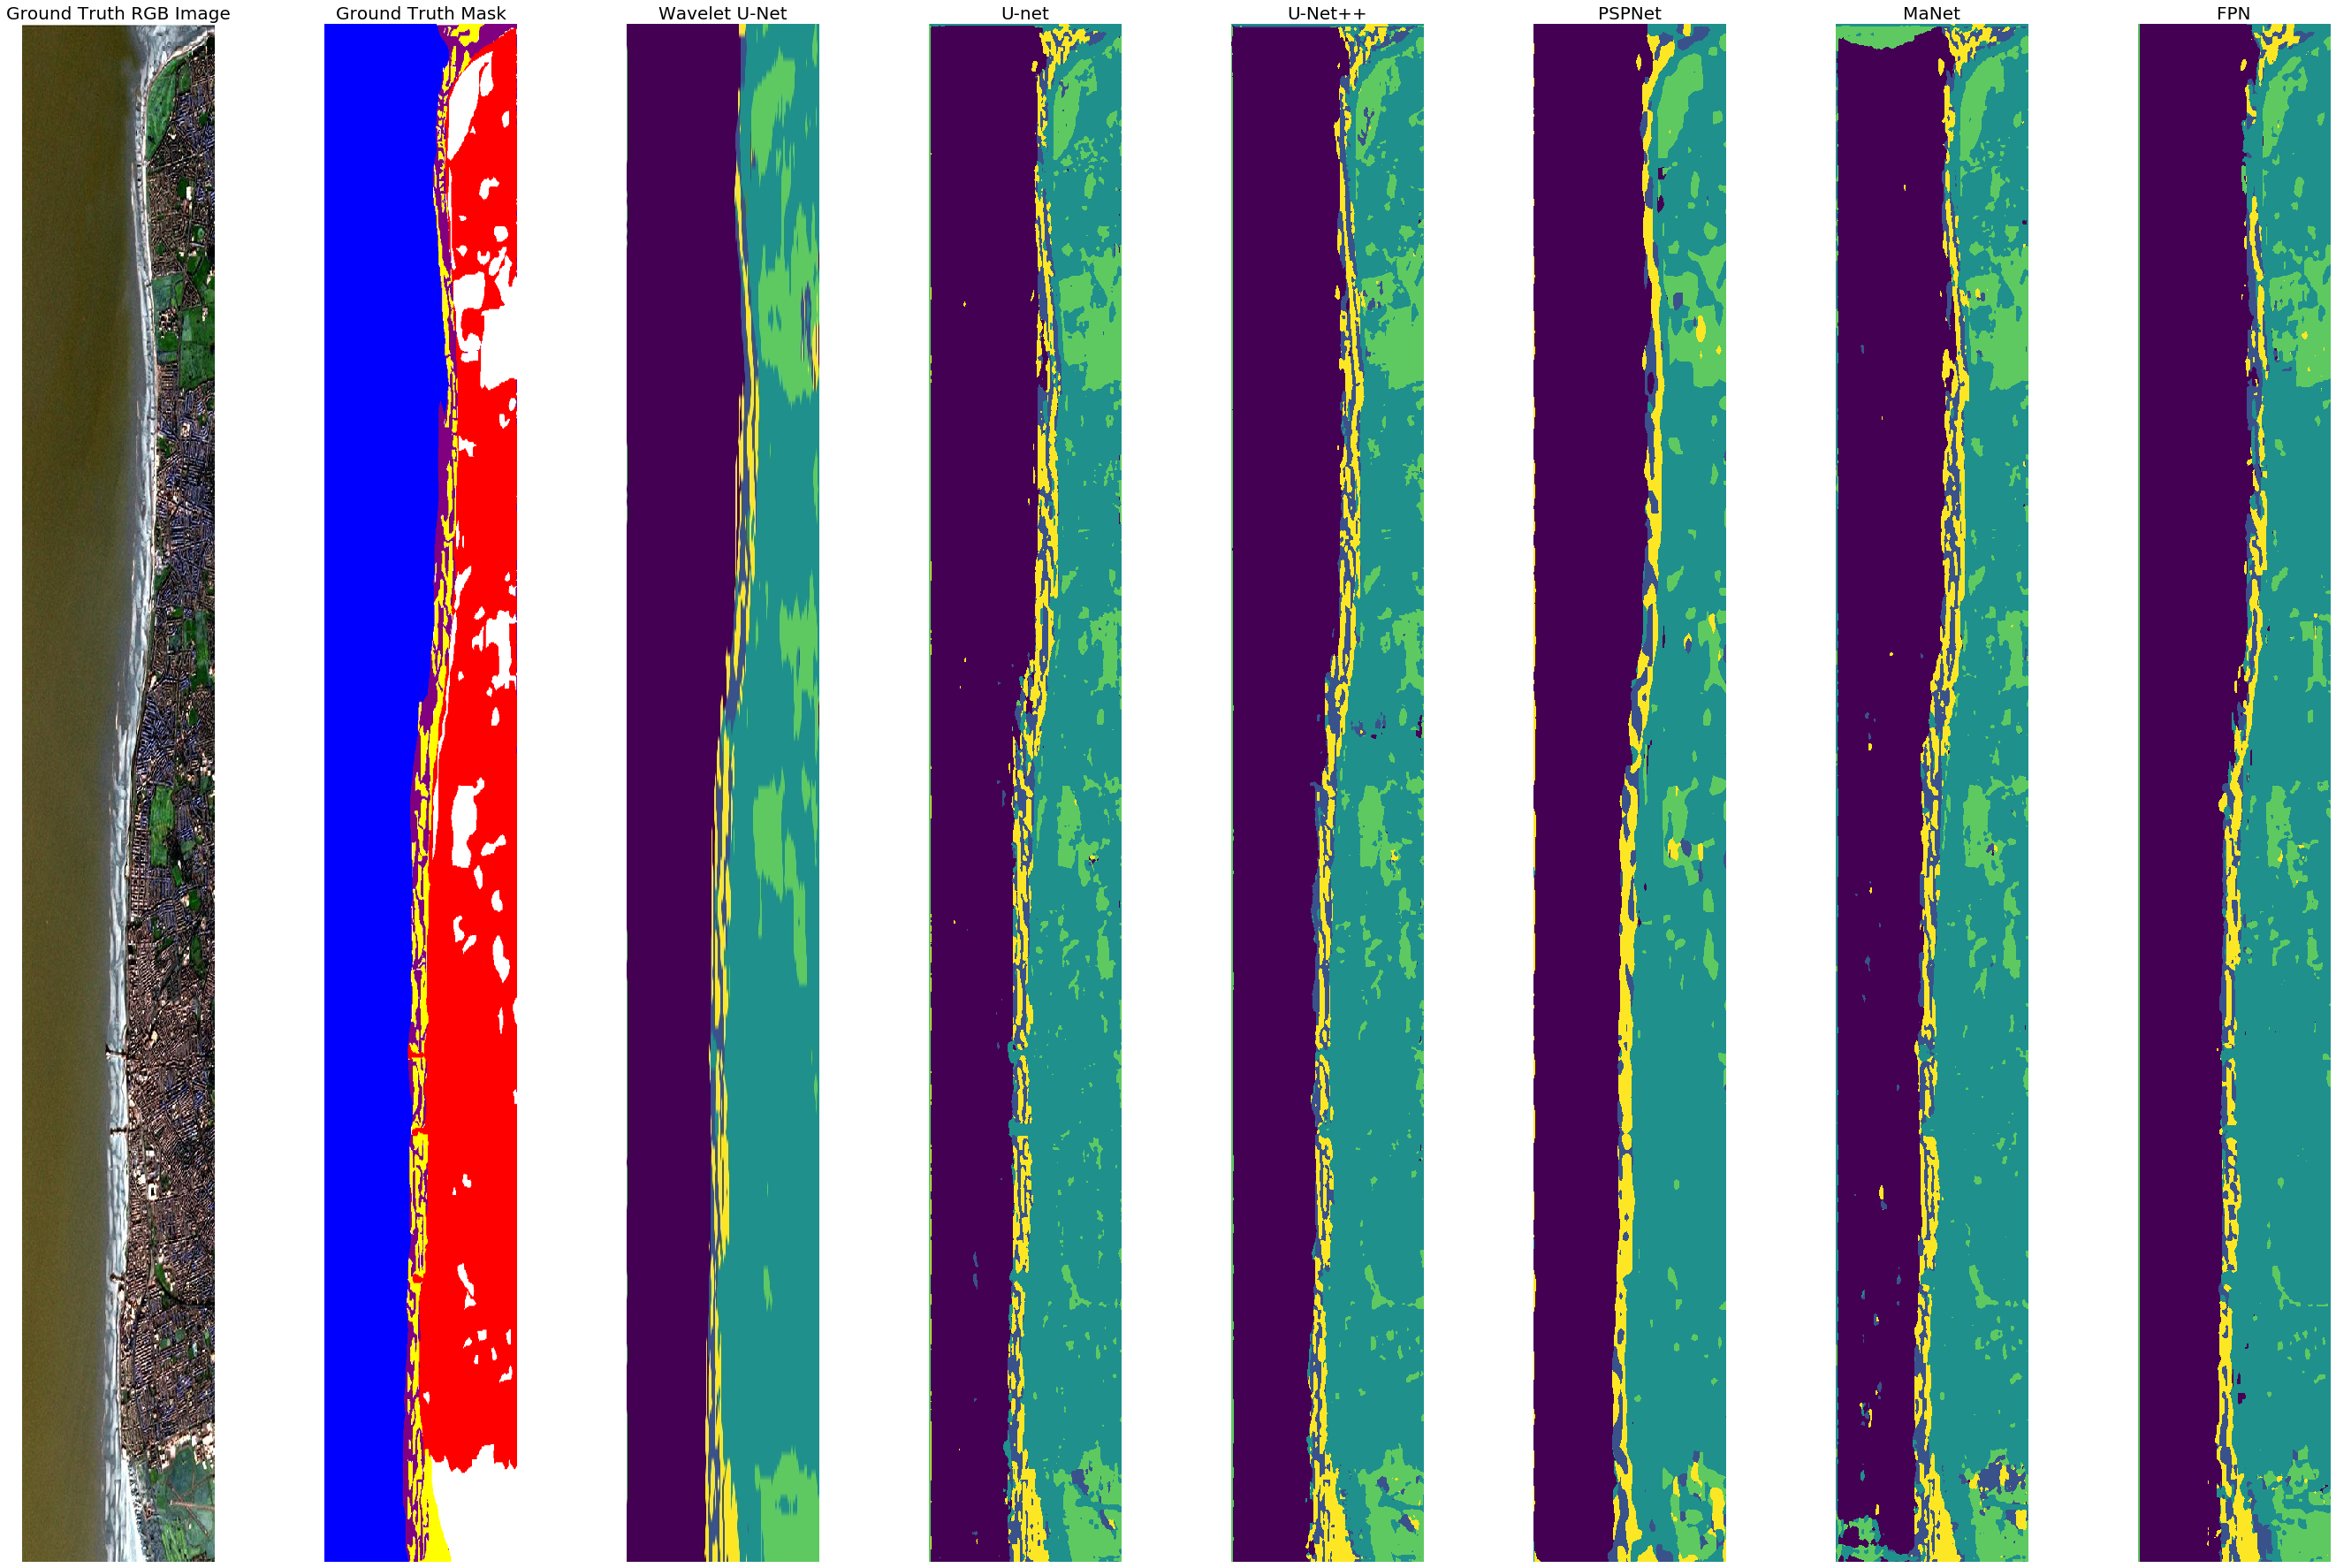

In [18]:

def show_images(images, cols = 1, titles = None):
    
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as images.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.axis('off')
        plt.imshow(image)
        a.set_title(title, fontdict={'fontsize': 20, 'fontweight': 'medium'})
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.savefig('./all_model_results.png')
    plt.show()
titles=['Ground Truth RGB Image', 'Ground Truth Mask', 'Wavelet U-Net', 'U-net', 'U-Net++', 'PSPNet', 'MaNet', 'FPN']
show_images(images=imgs, cols=1, titles=titles)